In [1]:
using LinearAlgebra
using Optim
using Plots
using Distributed
using HCubature
using BenchmarkTools
using DelimitedFiles
#plotly()

# formfactor, Sq

In [12]:
kb = 0.0862
r0=[0 0 0]/4
r1=[1 1 0]/4
r2=[1 0 1]/4
r3=[0 1 1]/4
rs=vcat(r0,r1,r2,r3)'

3×4 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0  0.25  0.25  0.0
 0.0  0.25  0.0   0.25
 0.0  0.0   0.25  0.25

  3.393802 seconds (7.11 M allocations: 423.077 MiB, 2.82% gc time, 74.33% compilation time)


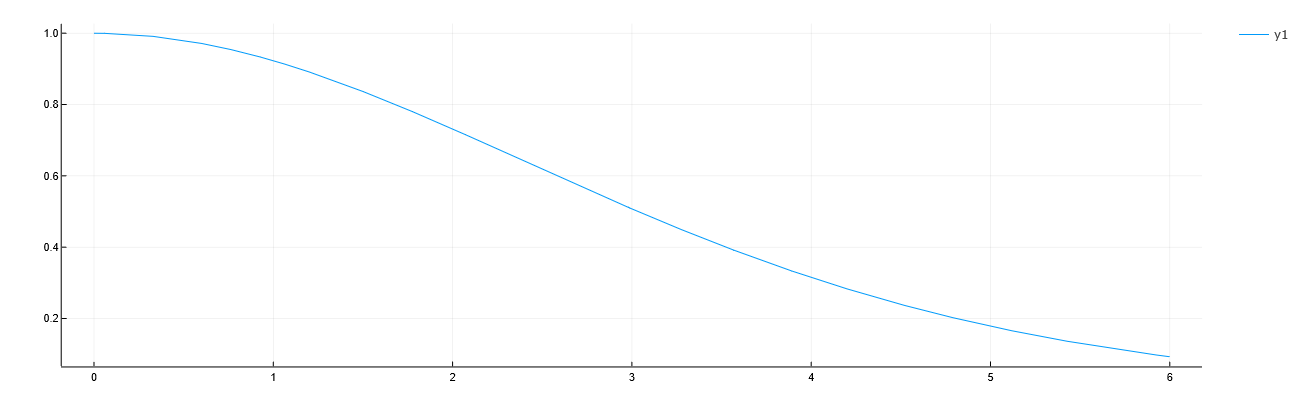

In [4]:
function gdfmsq(q)
    s=q/(4π)
    j=7/2
    l=0
    ss=7/2
    fc = (j*(j+1)-ss*(ss+1)+l*(l+1)) / (3*j*(j+1)+ss*(ss+1)-l*(l+1))
    fm = 0.0186*exp(-25.3867*s^2)+0.2895*exp(-11.1421*s^2)+0.7135*exp(-3.7520*s^2)-0.0217 + s^2*(0.3347*exp(-18.4758*s^2)+ 1.2465*exp(-6.8767*s^2)+0.9537*exp(-2.3184*s^2)+0.0217)*fc
    return fm^2
end
@time plot(gdfmsq,0,6)

## nn Jex

In [7]:

function Sq(Q, Jex, T)
    Phase = 2*real( transpose(exp.(im * Q*rs)) * exp.(-im * Q*rs) )
    #Phase = 2*reshape([cos(Q⋅(rs[:,j]-rs[:,i])) for i=1:4, j=1:4],4,4)
#     show(stdout,"text/plain",Phase)
    Phase[diagind(Phase)] .= 0
    val, vec = eigen(Jex.*Phase)
    
#     show(stdout,"text/plain",Phase)
#     show(stdout,"text/plain",vec')
#     show(stdout,"text/plain", val)
#     show(stdout,"text/plain", sum(vec,dims=1).^2)
#     show(stdout,"text/plain", (3*T*kb .- val'))
#     show(stdout,"text/plain", sum(vec,dims=1).^2)
    return sum(sum(vec,dims=1).^2 ./ (3*T*kb .- val'))
end
Sq(2π*[0.5 0 0], -1, 7.8)

0.5843248611253639

## 3nn Da Jex, Dip
One way to speed up: column major

In [5]:
fcc = [0    1/2. 1/2.; 
       1/2. 0    1/2.; 
       1/2. 1/2. 0   ]

scIdx = vec(collect(Iterators.product(-1:1, -1:1, -1:1)))
sc = [x[1].*fcc[1,:] + x[2].*fcc[2,:]+ x[3].*fcc[3,:] for x in scIdx]

#rss = hcat([rs[:,i]+sc[j] for i in 1:4 for j in 1:27]...) # a Matrix
rss = [rs[:,i]+sc[j] for i in 1:4 for j in 1:27] # a Array of Array

atomType = vec([i for i in 1:4 for j in 1:27])

function nn3(idAtom)
    dist = [norm(r.-rs[:,idAtom]) for r in rss]
    
    idAtom2 = sortperm(dist)[2:31]
    rAtom2 = rss[idAtom2]
    
    rij   = hcat([rAtom2[i] .- rs[:,idAtom] for i=1:30]...)
    typeAtom2 = atomType[idAtom2]
    
    bondCenters = [rAtom2[i].+rs[:,idAtom] for i=19:30]./2
    
    bondType = [1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2]
    #[any(all(center' .== rss; dims=2)) for center in bondCenters]
    bondType = vcat(bondType , [any([center].==rss) ? 3 : 4 for center in bondCenters]) #https://stackoverflow.com/questions/48747718/element-wise-comparison-of-vectors-of-tuples-julia
    return rij', typeAtom2, bondType, dist[idAtom2]
end

function nn3_col(idAtom)
    dist = [norm(r.-rs[:,idAtom]) for r in rss]
    
    idAtom2 = sortperm(dist)[2:31]
    rAtom2 = rss[idAtom2]
    
    rij   = hcat([rAtom2[i] .- rs[:,idAtom] for i=1:30]...)
    typeAtom2 = atomType[idAtom2]
    
    bondCenters = [rAtom2[i].+rs[:,idAtom] for i=19:30]./2
    
    bondType = [1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2]
    #[any(all(center' .== rss; dims=2)) for center in bondCenters]
    bondType = vcat(bondType , [any([center].==rss) ? 3 : 4 for center in bondCenters]) #https://stackoverflow.com/questions/48747718/element-wise-comparison-of-vectors-of-tuples-julia
    return rij, typeAtom2, bondType, dist[idAtom2] # Different from nn3
end

@show nn3(1)

@show nn3_col(1)


nn3(1) = ([-0.25 -0.25 0.0; 0.25 0.25 0.0; -0.25 0.0 -0.25; 0.25 0.0 0.25; 0.0 -0.25 -0.25; 0.0 0.25 0.25; -0.25 0.25 0.5; 0.25 -0.25 0.5; -0.25 0.25 -0.5; 0.25 -0.25 -0.5; -0.25 -0.5 0.25; -0.25 0.5 0.25; 0.25 -0.5 -0.25; 0.25 0.5 -0.25; -0.5 -0.25 0.25; -0.5 0.25 -0.25; 0.5 -0.25 0.25; 0.5 0.25 -0.25; -0.5 -0.5 0.0; -0.5 0.0 0.5; 0.0 -0.5 0.5; -0.5 0.0 -0.5; -0.5 0.5 0.0; 0.0 -0.5 -0.5; 0.0 0.5 0.5; 0.5 -0.5 0.0; 0.5 0.0 0.5; 0.0 0.5 -0.5; 0.5 0.0 -0.5; 0.5 0.5 0.0], [2, 2, 3, 3, 4, 4, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 3, 4, 3, 3, 4, 3, 4, 4, 3], [0.3535533905932738, 0.3535533905932738, 0.3535533905932738, 0.3535533905932738, 0.3535533905932738, 0.3535533905932738, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0

([-0.25 0.25 … 0.5 0.5; -0.25 0.25 … 0.0 0.5; 0.0 0.0 … -0.5 0.0], [2, 2, 3, 3, 4, 4, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 2, 2, 2, 2  …  4, 3, 4, 3, 3, 4, 3, 4, 4, 3], [0.3535533905932738, 0.3535533905932738, 0.3535533905932738, 0.3535533905932738, 0.3535533905932738, 0.3535533905932738, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945, 0.6123724356957945  …  0.7071067811865476, 0.7071067811865476, 0.7071067811865476, 0.7071067811865476, 0.7071067811865476, 0.7071067811865476, 0.7071067811865476, 0.7071067811865476, 0.7071067811865476, 0.7071067811865476])

In [7]:
# Prepare anisotropy matrix
# Loacal 111 aixs
n0=[1 1 1]
n1=[-1 -1 1]
n2=[-1 1 -1]
n3=[1 -1 -1]
ns = vcat(n0,n1,n2,n3)/sqrt(3)

DaMats = zeros(4,3,3)
for i=1:4
    DaMats[i,:,:] = ns[i,:]* reshape(ns[i,:],1,3)
end

# Prepare the Matrix for Jex and Dip
# Dipolar interactoins: rij: 4by30by3(4 atoms, 30 bonds per atom)
function DipMat(rij)
    return reshape([a==b ? 1-3*rij[a]*rij[b]/sum(rij.^2) : -3*rij[a]*rij[b]/sum(rij.^2) for a=1:3, b=1:3], (3,3))
end

rij, typeAtom2, bondType, DipMats = zeros(4,30,3), zeros(Int64,4,30), zeros(Int64, 4,30), zeros(4,30,3,3)
for i=1:4
    rij[i,:,:], typeAtom2[i,:], bondType[i,:], dist = nn3(i)
    for j=1:30
        DipMats[i,j,:,:] = DipMat(rij[i,j,:])
    end
end

# make const, 1000 times faster, reduced allocations
const typeAtom2_c, bondType_c, rij_c, DipMats_c, DaMats_c =  typeAtom2, bondType, rij, DipMats, DaMats

# using PyCall
# LA = pyimport("numpy.linalg")
#function Sq_3nnDaJexDip_fast_test(Q::Array{Float64,3}, Da::Float64, Jex0::Float64, Jex1::Float64, Jex2a::Float64, Jex2b::Float64, Dip0::Float64, T::Float64; Ham=zeros((4,4,3,3)), typeAtom2=typeAtom2, bondType=bondType, rij=rij, DipMats=DipMats, DaMats=DaMats)      
function Sq_3nnDaJexDip_fast(Q, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T)    
    Dip1, Dip2 = Dip0/5.196, Dip0/8. #1.732**3, 2**3
    Jexs = [Jex0, Jex1, Jex2a, Jex2b]
    Dips = [Dip0, Dip1, Dip2,  Dip2]

    Ham = zeros((4,4,3,3))
    for i=1:4
        for j=1:30
            k, l = typeAtom2_c[i,j], bondType_c[i,j]
            Ham[i,k,:,:] +=  (Jexs[l]*I - Dips[l].*DipMats_c[i,j,:,:]) .* cos( (Q*rij_c[i,j,:])[1] )
        end
    end

    for i=1:4
        Ham[i,i,:,:] += Da*(DaMats_c[i,:,:] - I)
    end

    Ham = reshape( permutedims(Ham, (4,2,3,1)), 12,12)# reshape in a  different way from Python

    val, vec = eigen(Ham) # val, vec = LA.eigh(HamJexDip) # vec is different from python but the Sq result is good

    Fq = dropdims(sum(reshape(vec,3,4,12); dims=2); dims=2)
    Fq_perp = Fq .- Q' * (Q*Fq) ./ sum(Q.^2)
    return sum( sum(Fq_perp.^2; dims=1) ./ (3*T*kb .- val') )
end
    
@time Sq_3nnDaJexDip_fast(2π.*[0 0 2], 0., -0.166, 0.,0.,0.,0.01,2.)

  0.160442 seconds (441.88 k allocations: 24.247 MiB, 12.75% gc time, 99.03% compilation time)


47.444945307617026

In [13]:
### Function with slicing based Columns (faster)
# Prepare anisotropy matrix
# Loacal 111 aixs
n0=[1 1 1]
n1=[-1 -1 1]
n2=[-1 1 -1]
n3=[1 -1 -1]
ns = vcat(n0,n1,n2,n3)/sqrt(3)

DaMats = zeros(3,3,4)
for i=1:4
    DaMats[:,:,i] = ns[i,:]* reshape(ns[i,:],1,3)
end

# Prepare the Matrix for Jex and Dip
# Dipolar interactoins: rij: 4by30by3(4 atoms, 30 bonds per atom)
function DipMat(rij)
    return reshape([a==b ? 1-3*rij[a]*rij[b]/sum(rij.^2) : -3*rij[a]*rij[b]/sum(rij.^2) for a=1:3, b=1:3], (3,3))
end

rij, typeAtom2, bondType, DipMats = zeros(3,30,4), zeros(Int64,30,4), zeros(Int64,30,4), zeros(3,3,30,4)
for i=1:4
    rij[:,:,i], typeAtom2[:,i], bondType[:,i], dist = nn3_col(i)
    for j=1:30
        DipMats[:,:,j,i] = DipMat(rij[:,j,i])
    end
end

const typeAtom2_c, bondType_c, rij_c, DipMats_c, DaMats_c =  typeAtom2, bondType, rij, DipMats, DaMats

# using PyCall
# LA = pyimport("numpy.linalg")

function Sq_3nnDaJexDip_fast_col(Q, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T)    
    Dip1, Dip2 = Dip0/5.196, Dip0/8. #1.732**3, 2**3
    Jexs = [Jex0, Jex1, Jex2a, Jex2b]
    Dips = [Dip0, Dip1, Dip2,  Dip2]
    
    Ham=zeros((3,3,4,4))
    for i=1:4
        for j=1:30
            k, l = typeAtom2_c[j,i], bondType_c[j,i]
            Ham[:,:,k,i] += (Jexs[l]*I - Dips[l].*DipMats_c[:,:,j,i]) .* cos( (Q*rij_c[:,j,i])[1] )
        end
    end
    
    for i=1:4
        Ham[:,:,i,i] += Da*(DaMats_c[:,:,i] - I)
    end
    
    Ham = reshape( permutedims(Ham, (1,3,2,4)), 12,12)# reshape in a  different way from Python

    val, vec = eigen(Ham) # val, vec = LA.eigh(HamJexDip) # vec is different from python but the Sq result is good

    Fq = dropdims(sum(reshape(vec,3,4,12); dims=2); dims=2)
    Fq_perp = Fq .- Q' * (Q*Fq) ./ sum(Q.^2)
    return sum( sum(Fq_perp.^2; dims=1) ./ (3*T*kb .- val') )

end

@time Sq_3nnDaJexDip_fast_col(2π.*[0 0 2], 0 ,-0.166,0,0,0,0.01,2.)

  0.076850 seconds (225.71 k allocations: 12.307 MiB, 20.27% gc time, 97.88% compilation time)


47.444945307617026

In [37]:
# Compare with SpinW dipolar matrix (using real rij with g tensor, do not include SiSj)
u0_4pi_4uB2_rnn3 = 0.066/(3.5*4.5) 
@show rij[:,3,1]
@show DipMats[:,:,3,1]*u0_4pi_4uB2_rnn3 # (consistent!!!)
@show rij[:,16,1]
DipMats[:,:,16,1]*u0_4pi_4uB2_rnn3/5.196 # (consistent with bond 3440, rij=6.*(RR(:,378)-RR(:,959))=[-0.5 0.25 -0.25]   )

rij[:, 3, 1] = [-0.25, 0.0, -0.25]
DipMats[:, :, 3, 1] * u0_4pi_4uB2_rnn3 = [-0.0020952380952380953 0.0 -0.006285714285714286; 0.0 0.004190476190476191 0.0; -0.006285714285714286 0.0 -0.0020952380952380953]
rij[:, 16, 1] = [-0.5, 0.25, -0.25]


3×3 Matrix{Float64}:
 -0.000806481  0.000806481  -0.000806481
  0.000806481  0.000403241   0.000403241
 -0.000806481  0.000403241   0.000403241

In [4]:
ts = collect(2.0:-0.05:0.9)
Cp = [3.8590 3.9740 3.9337 4.1308 4.2365 4.3203 4.5858 4.5839 4.6734 4.8151 4.8894 5.1295 5.2808 5.5090 5.6175 5.6170 5.8788 6.0418 6.0588 6.4767 6.8225 7.0013 7.0905]

1×23 Matrix{Float64}:
 3.859  3.974  3.9337  4.1308  4.2365  …  6.4767  6.8225  7.0013  7.0905

In [11]:
Cp[5,1]

LoadError: BoundsError: attempt to access 1×23 Matrix{Float64} at index [5, 1]

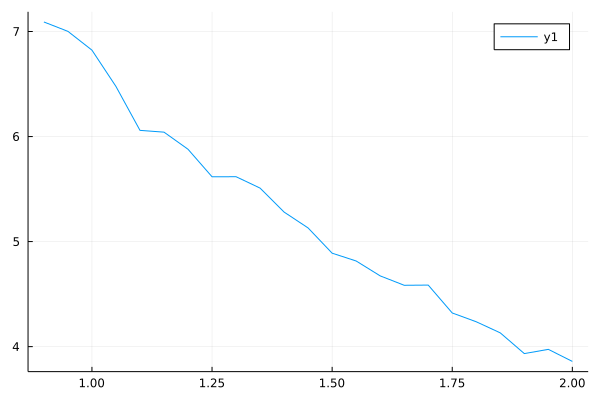

In [6]:
plot(ts,Cp')

In [70]:
using Profile

@profile Sq_3nnDaJexDip_fast(2π.*[0 0 2], 0 ,-0.166,0,0,0,0.01,2.)
text = Profile.print(format=:flat)

# open("D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/julia_profile.txt", "w+") do io
#            #writedlm(io, text)
#             Profile.print(io, format=:flat)
#        end

 Count  Overhead File                    Line Function
 =====  ======== ====                    ==== ========
     1         1 In[52]                    40 Sq_3nnDaJexDip_fast(::Array{Flo...
     6         0 In[52]                    50 Sq_3nnDaJexDip_fast(::Array{Flo...
     2         0 @Base\broadcast.jl      1263 broadcasted(::Function, ::Float...
     2         2 @Base\broadcast.jl      1265 broadcasted
     1         0 ...ctinterpretation.jl    57 #216
     1         0 ...ctinterpretation.jl   635 abstract_apply(::Any, ::Any, ::...
     1         0 ...ctinterpretation.jl   911 abstract_call(::Array{Any,1}, :...
     1         0 ...ctinterpretation.jl   924 abstract_call(::Array{Any,1}, :...
     1         0 ...ctinterpretation.jl   926 abstract_call(::Array{Any,1}, :...
     1         0 ...ctinterpretation.jl    55 abstract_call_gf_by_type(::Any,...
     1         0 ...ctinterpretation.jl   111 abstract_call_gf_by_type(::Any,...
     1         0 ...ctinterpretation.jl   704 abstra

  2.344652 seconds (7.88 M allocations: 896.380 MiB, 7.06% gc time, 36.47% compilation time)


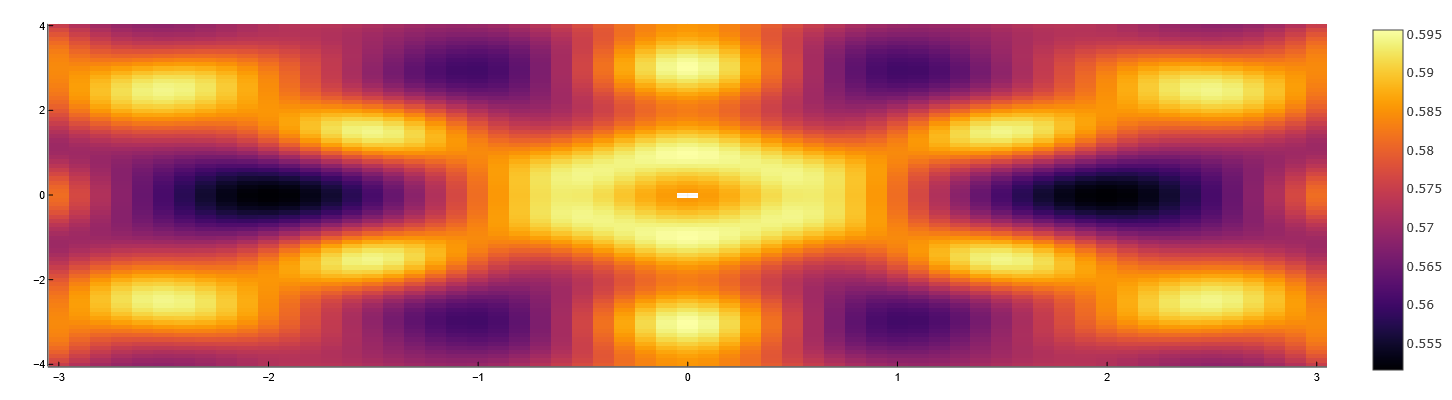

In [11]:
x = -3:0.1:3
y = -4:0.1:4
# Sqs(x,y) = begin Sq([x,x,y], -1, 20)
# end
# hhl = [[i,i,j] for i=x for j=y ]
# @time sqs = [Sq_3nnDaJexDip_fast_col(2π.*[x x y], 100 ,0*0.166,0,0,0,0.066,20) for x in x for y in y]

#@time heatmap(x, y, (x,y)->Sq(2π.*[x x y],-1,7.8), fill=true)
@time heatmap(x, y, (x,y)->Sq_3nnDaJexDip_fast_col(2π.*[x x y], 100 , 0*0.166,0,0,0,0.066,20), fill=true)

# Sq for powder

In [15]:
SqPolar(q, θ, ϕ, Jex, T) = Sq([q*sin(θ)cos(ϕ) q*sin(θ)sin(ϕ) q*cos(θ)], Jex, T)*sin(θ)
SqPolar_3nn(q, θ, ϕ, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T) = Sq_3nnDaJexDip_fast_col([q*sin(θ)cos(ϕ) q*sin(θ)sin(ϕ) q*cos(θ)], Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T)*sin(θ)
@time SqPolar(1, π/3, π/2, -1, 8)

  0.000246 seconds (51 allocations: 5.375 KiB)


0.4383226127272428

In [1]:
# SqPowder(q, Jex,T) = hcubature(x->SqPolar(q,x[1],x[2],Jex,T), [0., 0.], [π/2, π/4])
# SqPowder_3nn(q, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T) = hcubature(x->SqPolar_3nn(q,x[1],x[2], Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T), [0, 0], [π/2, π/4])
# #SqPowder(q, Jex,T) = hcubature_v((x,v)->v=SqPolar(q,x[1],x[2],Jex,T), [0, 0], [π/2, π/4]) # vectorized function is not in the package
# @time SqPowder(1,-1,7.8)
# @time SqPowder_3nn(10.5, 0 ,-0.166,0,0,0,0.066,30)

SqPowder_func(q,func,args...) = hcubature(x->func(q,x[1],x[2], args...), [0., 0.], [π/2, π/4])
@time SqPowder_func(1, SqPolar,-1,7.8)
@time SqPowder_func(10.5, SqPolar_3nn, 0, -0.166,0,0,0,0.066,30)

LoadError: UndefVarError: SqPolar not defined

In [17]:
rmprocs(workers()) #  Remove the workers you created.

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\Distributed\src\cluster.jl:1038


Task (done) @0x000000005c5aa400

In [18]:

#@time sqs = [SqPowder(q*10.5, -0.166, 1.3, Sq_3nnDaJexDip_fast) for q in x]
#@time sqs = [SqPowder_func(q*10.5, SqPolar_3nn, 0,-0.166,0,0,0,0.066,3) for q in x]

addprocs(8)
# sqs = zeros((2,30))
# @distributed for idx = 1:30
#         sqs[:,idx] .= SqPowder_func(x[idx]*10.5, SqPolar_3nn, 0,-0.166,0,0,0,0.066,3)
#     end
#plot(x, first.(sqs))
# @everywhere begin
#     x = 0.1:0.1:3
#     pmap(x->SqPowder_func(x*10.5, SqPolar_3nn, 0,-0.166,0,0,0,0.066,3),x)
# end
rmprocs(workers()) #  Remove the workers you created.

Task (done) @0x000000000f8dc4c0

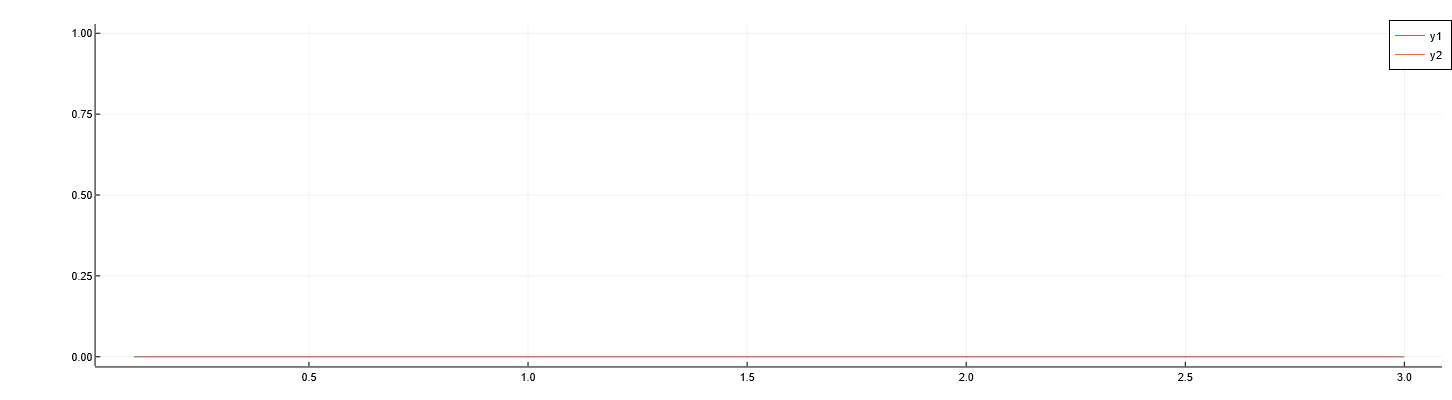

In [38]:
plot(x, first.(sqs'))

In [37]:
# Save to txt for comparing with python and matlab
open("D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/MF_Sq_julia.txt", "w+") do io
           writedlm(io, [x first.(sqs) last.(sqs)])
       end

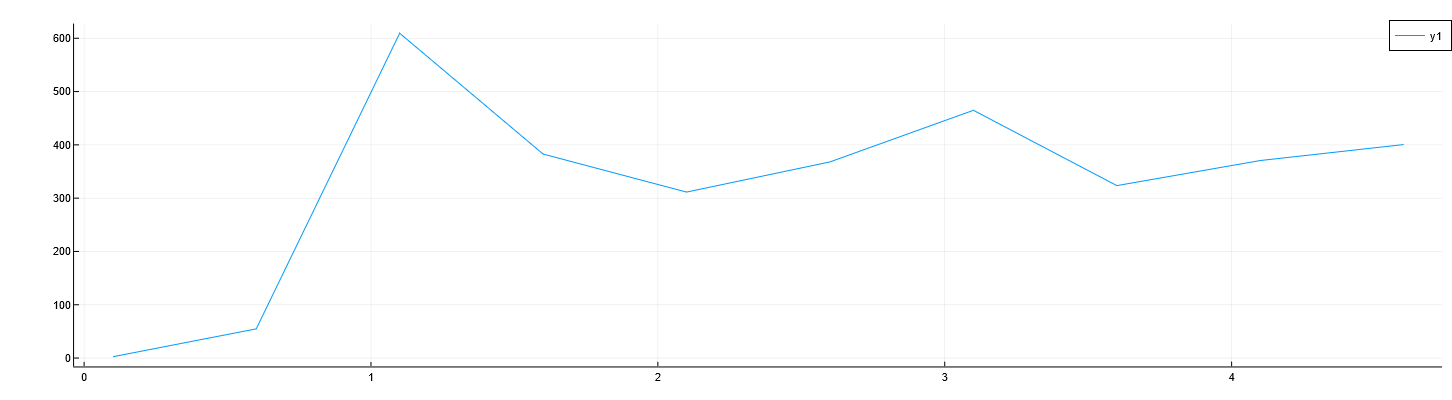

In [484]:
plot(x,first.(sqs))

# Parallel computing

In [1]:
rmprocs(workers()) #  Remove the workers you created.

LoadError: UndefVarError: workers not defined

In [13]:
# First have to add workers!!!
addprocs(26)
# Define parallel function and apply pmap on the function
@everywhere begin
    using LinearAlgebra
    r0=[0 0 0]/4
    r1=[1 1 0]/4
    r2=[1 0 1]/4
    r3=[0 1 1]/4
    rs=vcat(r0,r1,r2,r3)'
    
    kb = 0.0862
    function Sq(Q, Jex,T)
        Phase = 2*real( transpose(exp.(im * Q*rs)) * exp.(-im .* Q*rs) )
        Phase[diagind(Phase)] .= 0
        val, vec = eigen(Jex.*Phase)
        return sum(sum(vec,dims=1).^2 ./ (3*T*kb .- val'))
    end
    
    using HCubature
    function pSqPowder(q, Jex, T)
        hcubature(x->Sq([q*sin(x[1])cos(x[2]) q*sin(x[1])sin(x[2]) q*cos(x[1])],-1., 8.)*sin(x[1]), [0, 0], [π/2, π/4])
    end
end

@time pmap(q->(println("process id = $(myid()) q = $q"); pSqPowder(q, -1, 7.8)), 1.:2:50)

rmprocs(workers()) #  Remove the workers you created.

      From worker 3:	process id = 3 q = 29.0
      From worker 18:	process id = 18 q = 11.0
      From worker 17:	process id = 17 q = 3.0
      From worker 9:	process id = 9 q = 9.0
      From worker 22:	process id = 22 q = 13.0
      From worker 8:	process id = 8 q = 35.0
      From worker 2:	process id = 2 q = 1.0
      From worker 6:	process id = 6 q = 17.0
      From worker 16:	process id = 16 q = 33.0
      From worker 11:	process id = 11 q = 43.0
      From worker 20:	process id = 20 q = 39.0
      From worker 27:	process id = 27 q = 37.0
      From worker 7:	process id = 7 q = 31.0
      From worker 24:	process id = 24 q = 45.0
      From worker 15:	process id = 15 q = 49.0
      From worker 5:	process id = 5 q = 5.0
      From worker 25:	process id = 25 q = 15.0
      From worker 21:	process id = 21 q = 7.0
      From worker 14:	process id = 14 q = 23.0
      From worker 13:	process id = 13 q = 27.0
      From worker 26:	process id = 26 q = 21.0
      From worker 19:	process id

Task (done) @0x00000000333919f0

In [16]:
# First have to add workers!!!
addprocs(26)
# Define parallel function and use pmap in it
@everywhere begin
    using LinearAlgebra
    using HCubature
    function parSqPowder(qs,Jex, T)  
        r0=[0 0 0]/4
        r1=[1 1 0]/4
        r2=[1 0 1]/4
        r3=[0 1 1]/4
        rs=vcat(r0,r1,r2,r3)'

        kb = 0.0862
        function Sq(Q, Jex, T)
            Phase = 2*real( transpose(exp.(im * Q*rs)) * exp.(-im .* Q*rs) )
            Phase[diagind(Phase)] .= 0
            val, vec = eigen(Jex.*Phase)
            return sum(sum(vec,dims=1).^2 ./ (3*T*kb .- val'))
        end

        function SqPowder(q, Jex, T)
            hcubature(x->Sq([q*sin(x[1])cos(x[2]) q*sin(x[1])sin(x[2]) q*cos(x[1])], Jex, T)*sin(x[1]), [0, 0], [π/2, π/4])
        end
        
        return hcat(pmap(q->collect(SqPowder(q, Jex, T)), qs)...) #pmap(q->(println("process id = $(myid()) q = $q"); SqPowder(q, Jex, T)), qs)
        # collect: tuple -> array; hcat(A...): array of array -> 2d array(2 by N)
    end    
end

@time parSqPowder(1.:2:50, -1., 7.8)
#rmprocs(workers()) #  Remove the workers you created.

 83.120396 seconds (859.16 k allocations: 52.872 MiB, 0.01% gc time)


2×25 Array{Float64,2}:
 0.403671    0.915659    4.81634     21.2374      …  98.7518      97.722
 5.46933e-9  1.33644e-8  7.13736e-8   3.14779e-7      1.47142e-6   1.45605e-6

In [12]:
# Example of using pmap
#https://stackoverflow.com/questions/24637println("process id = $(myid())064/julia-using-pmap-correctly
#addprocs(3)
@everywhere f(s,count)=(println("process id = $(myid()) s = $s count = $count");repeat(s,count))
pmap((a1,a2)->f(a1,a2),["a","b","c"],[2,1,3])

process id = 1 s = a count = 2
process id = 1 s = b count = 1
process id = 1 s = c count = 3


3-element Array{String,1}:
 "aa"
 "b"
 "ccc"

In [11]:
rmprocs(workers())

Task (done) @0x0000000013dd1fb0

# Load and fitting data

In [11]:
# Load and reduce data
data = readdlm("D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed/35mK_data.txt")
data_part = data[1:10:end, 1:2]
data_part[:,2] = data_part[:,2]./gdfmsq.(data_part[:,1])
data_part[:,1] = data_part[:,1].*10.5
data_part

20×2 Array{Float64,2}:
  3.22682  0.724626
  5.68706  1.50687
  8.05433  3.46581
 10.4975   9.74544
 12.9005   9.25566
 15.1612   7.15461
 17.4543   4.2224
 19.5911   3.55048
 21.278    3.85202
 22.9926   4.53691
 24.6326   4.51179
 26.2259   4.54962
 27.7602   4.96674
 29.242    5.66123
 30.6066   6.3444
 34.1926   6.18856
 35.5783   4.81936
 38.3551   4.27173
 39.3063   3.36558
 40.0895   3.45662

In [ ]:
rmprocs(workers()) #  Remove the workers you created.

In [ ]:
# Define minimize target
# First have to add workers!!!
addprocs(22)
@everywhere begin
    using LinearAlgebra
    using HCubature
    function minTarget(s, Jex, T)  
        r0=[0 0 0]/4
        r1=[1 1 0]/4
        r2=[1 0 1]/4
        r3=[0 1 1]/4
        rs=vcat(r0,r1,r2,r3)'

        kb = 0.0862
        function Sq(Q, Jex, T)
            Phase = 2*real( transpose(exp.(im * Q*rs)) * exp.(-im .* Q*rs) )
            Phase[diagind(Phase)] .= 0
            val, vec = eigen(Jex.*Phase)
            return sum(sum(vec,dims=1).^2 ./ (3*T*kb .- val'))
        end

        function SqPowder(q, Jex, T)
            hcubature(x->Sq([q*sin(x[1])cos(x[2]) q*sin(x[1])sin(x[2]) q*cos(x[1])], Jex, T)*sin(x[1]), [0, 0], [π/2, π/4])
        end
        
        return sum( (collect(s * pmap(q->SqPowder(q, Jex, T)[1], data_part[:,1])) - data_part[:,2]).^2 ) #pmap(q->(println("process id = $(myid()) q = $q"); SqPowder(q, Jex, T)), qs)
    end    
end
@time minTarget(1.2, -0.166, 2.7)

      From worker 113:	Internal error: encountered unexpected error in runtime:
      From worker 106:	
      From worker 106:	Please submit a bug report with steps to reproduce this fault, and any error messages that follow (in their entirety). Thanks.


Worker 114 terminated.

      From worker 106:	Exception: UNKNOWN at 0x7ffe45df9689 -- RaiseException at C:\Windows\System32\KERNELBASE.dll (unknown line)


      From worker 106:	in expression starting at none:0
      From worker 106:	RaiseException at C:\Windows\System32\KERNELBASE.dll (unknown line)
      From worker 127:	
      From worker 127:	Please submit a bug report with steps to reproduce this fault, and any error messages that follow (in their entirety). Thanks.

Worker 113 terminated.
Worker 110 terminated.
Worker 127 terminated.



      From worker 127:	Exception: UNKNOWN at 0x7ffe45df9689 -- RaiseException at C:\Windows\System32\KERNELBASE.dll (unknown line)
      From worker 127:	in expression starting at none:0
      From worker 127:	RaiseException at C:\Windows\System32\KERNELBASE.dll (unknown line)
      From worker 127:	Unwind_RaiseException at C:\Users\jxu\AppData\Local\Programs\Julia 1.5.3\bin\libgcc_s_seh-1.dll (unknown line)


Worker 124 terminated.
Worker 107 terminated.
Worker 123 terminated.
Worker 106 terminated.


      From worker 110:	
      From worker 110:	Please submit a bug report with steps to reproduce this fault, and any error messages that follow (in their entirety). Thanks.
      From worker 110:	Exception: UNKNOWN at 0x7ffe45df9689 -- RaiseException at C:\Windows\System32\KERNELBASE.dll (unknown line)
      From worker 110:	in expression starting at none:0
      From worker 110:	RaiseException at C:\Windows\System32\KERNELBASE.dll (unknown line)
      From worker 110:	Unwind_RaiseException at C:\Users\jxu\AppData\Local\Programs\Julia 1.5.3\bin\libgcc_s_seh-1.dll (unknown line)
      From worker 122:	Internal error: encountered unexpected error in runtime:
      From worker 122:	jlbacktrace at C:\Users\jxu\AppData\Local\Programs\Julia 1.5.3\bin\libjulia.dll (unknown line)


Worker 111 terminated.


      From worker 122:	jl_gc_alloc at C:\Users\jxu\AppData\Local\Programs\Julia 1.5.3\bin\libjulia.dll (unknown line)
      From worker 122:	jl_gdb_dump_threadinfo at C:\Users\jxu\AppData\Local\Programs\Julia 1.5.3\bin\libjulia.dll (unknown line)
      From worker 122:	jl_array_cconvert_cstring at C:\Users\jxu\AppData\Local\Programs\Julia 1.5.3\bin\libjulia.dll (unknown line)
      From worker 122:	jl_array_cconvert_cstring at C:\Users\jxu\AppData\Local\Programs\Julia 1.5.3\bin\libjulia.dll (unknown line)
      From worker 122:	jl_uncompress_ir at C:\Users\jxu\AppData\Local\Programs\Julia 1.5.3\bin\libjulia.dll (unknown line)
      From worker 122:	unknown function (ip: 0000000009106c3c)
      From worker 122:	unknown function (ip: 0000000008c835b3)
      From worker 122:	unknown function (ip: 00000000088240f5)
      From worker 122:	unknown function (ip: 00000000088242c8)
      From worker 122:	jl_type_infer at C:\Users\jxu\AppData\Local\Programs\Julia 1.5.3\bin\libjulia.dll (unknown 

In [ ]:
# Find starting parameters from a plot
plot(data_part[:,1],data_part[:,2])
plot!(data_part[:,1], 1.2*SqPowder(data_part[:,1], -0.166, 1.3)[1,:])
# display()
# sum( (data_part[:,2]-1.2*parSqPowder(data_part[:,1], -0.166, 2.7)[1,:]).^2)

In [15]:
@time optimize(x->minTarget(x[1], x[2], x[3]), [1.2, -0.166, 3])

343.353323 seconds (2.42 M allocations: 127.475 MiB, 0.01% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     3.672985e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   336  (vs limit Inf)
    Iterations:    97
    f(x) calls:    182


In [22]:
Optim.minimizer(ans)

LoadError: MethodError: no method matching minimizer(::Task)
Closest candidates are:
  minimizer(!Matched::Optim.OptimizationResults) at C:\Users\jxu\.julia\packages\Optim\auGGa\src\api.jl:2

 23.499988 seconds (108.97 M allocations: 9.862 GiB, 4.84% gc time)


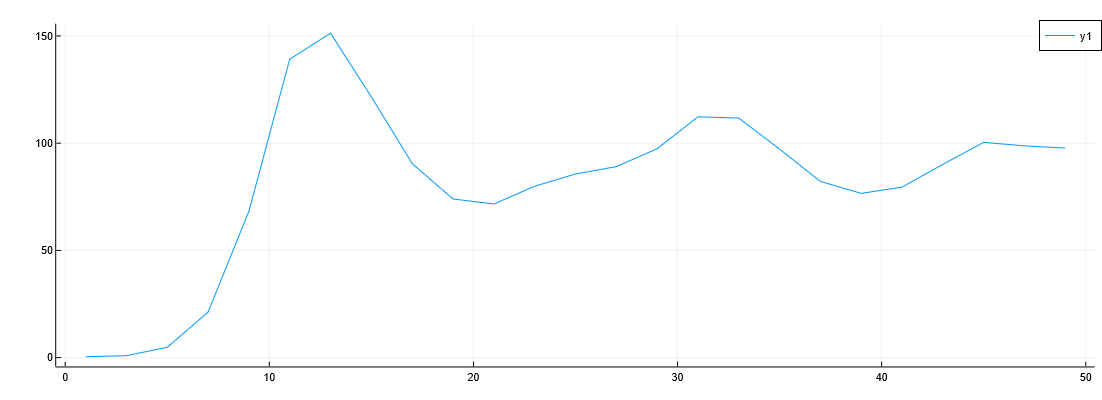

In [38]:
@time plot(q->SqPowder(q,-1,7.8)[1], 1:2:50, rtol=0.1)

In [10]:
f(x) = sin(x)+cos(x)
Optim.optimize(f,0.0,2π) # Find a minimum between 0 and 2π

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 6.283185]
 * Minimizer: 3.926991e+00
 * Minimum: -1.414214e+00
 * Iterations: 11
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 12

In [3]:
# p1 = plot(x, y) # Make a line plot
# p2 = scatter(x, y) # Make a scatter plot
# p3 = plot(x, y, xlabel = "This one is labelled", lw = 3, title = "Subtitle")
# p4 = histogram(x, y) # Four histograms each with 10 points? Why not!
# plot(p1, p2, p3, p4, layout = (2, 2), legend = false)

In [82]:
function test(a, b)
    for i in 1:size(a,3)
        @views @. 5.0 * a[:,1,i] + a[:,1,i] / 2.0 + 4.0
    end
end

a = rand(3, 3, 50)
b = rand(3, 3)

@time test(a, b)

  0.079437 seconds (346.42 k allocations: 16.735 MiB)
